<h2>Music014/102 Lab2: Tonality and Pitch Space</h2>
<h2>Prof. Michael Casey</h2>
<h2>Dartmouth College</h2>

In [1]:
# import libraries that we will use
from pylab import * 
import glob
%matplotlib inline
rcParams['figure.figsize'] = (14, 8)

In [2]:
# Tonal analysis utility functions. These operate on a 128 x T piano-roll score matrix.

pitch_classes = ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B']
pc_labels = tile(pitch_classes, 13) # Make pitch labels for whole range of piano roll

def pitch_distribution(mtx, tstr=''):
    """                                                                                                          
    Given a piano-roll matrix, 128 pitches x T beats, plot the pitch class histogram                           
    """
    i_min, i_max = where(mtx.mean(1))[0][[0,-1]]
    pd = mtx[i_min:i_max+1,:].sum(1)
    stem(arange(i_max+1-i_min),pd)
    ttl = 'Pitch Distribution'
    if tstr: ttl+=': '+tstr
    title(ttl,fontsize=16)    
    nskip = 3 if mtx.shape[0]>12 else 1 # figure out how many labels to show
    t=xticks(arange(0,i_max+1-i_min,nskip),pc_labels[i_min:i_max+1:nskip],fontsize=14)
    xlabel('Pitch Class', fontsize=14)
    ylabel('Frequency', fontsize=14)
    ax = axis()
    axis(xmin=-0.5)
    grid()
    return pd, arange(i_min,i_max+1) # return pitch frequencies and ranges

def scale_mtx(M, normalize=False, dbscale=False, norm=False, bels=False):                                                                  
    """                                                                                                                                    
    ::                                                                                                                                     
                                                                                                                                           
        Perform mutually-orthogonal scaling operations, otherwise return identity:                                                         
          normalize [False]                                                                                                                
          dbscale  [False]                                                                                                                 
          norm      [False]                                                                                                                
    """                                                                                                                                    
    if not (normalize or dbscale or norm or bels):                                                                                         
        return M                                                                                                                           
    else:                                                                                                                                  
        X = M.copy() # don't alter the original                                                                                            
        if norm:                                                                                                                           
            nz_idx = (X*X).sum(1) > 0                                                                                                      
            X[nz_idx] = (X[nz_idx].T / np.sqrt((X[nz_idx]*X[nz_idx]).sum(1))).T                                                            
        if normalize:                                                                                                                      
            X=X-np.min(X)                                                                                                                  
            X=X/np.max(X)                                                                                                                  
        if dbscale or bels:                                                                                                                
            X = P.log10(P.clip(X,0.0001,X.max()))                                                                                          
            if dbscale:                                                                                                                    
                X = 20*X                                                                                                                   
    return X     

def fold_octaves(mtx, tstr=''):
    """                                                                                                          
    Given a piano-roll matrix, 128 pitches x T beats, fold and sum values into a single octave
    """
    noctaves = 10 # We only have 10 complete octaves, last few very high pitches are discarded
    return mtx[:noctaves*12].reshape(noctaves,12,-1).sum(0)

def win_mtx(a, win_len=8):
    """                                                                                                                                    
    temporally integrate a score matrix
    """
    N = int(floor(a.shape[1]/float(win_len)))
    aa = a[:,:N*win_len].reshape(-1, N, win_len)
    return aa.mean(2) # temporally integrate

def plot_mtx(mtx=None, ttl=None, newfig=False, cbar=False, **kwargs):
    """                                                                                                          
      plot ascore matrix as a piano roll                     
    """
    if mtx is None or type(mtx) != ndarray:
        raise ValueError('First argument, mtx, must be a array')
    if newfig: figure()
    dbscale = kwargs.pop('dbscale', False)
    bels = kwargs.pop('bels',False)
    norm = kwargs.pop('norm',False)
    normalize = kwargs.pop('normalize',False)
    origin=kwargs.pop('origin','lower')
    aspect=kwargs.pop('aspect','auto')
    interpolation=kwargs.pop('interpolation','nearest')
    cmap=kwargs.pop('cmap',cm.gray_r)
    clip=-100.
    X = scale_mtx(mtx, normalize=normalize, dbscale=dbscale, norm=norm, bels=bels)
    i_min, i_max = where(X.mean(1))[0][[0,-1]]
    X = X[i_min:i_max+1].copy()
    if dbscale or bels:
        if bels: clip/=10.
        imshow(clip(X,clip,0),origin=origin, aspect=aspect, interpolation=interpolation, cmap=cmap, **kwargs)
    else:
        imshow(X,origin=origin, aspect=aspect, interpolation=interpolation, cmap=cmap, **kwargs)
    if title:
        title(ttl,fontsize=16)
    if cbar:
        colorbar()
    nskip = 3 if mtx.shape[0]>12 else 1 # figure out how many labels to show
    yticks(arange(0,i_max+1-i_min,nskip),pc_labels[i_min:i_max+1:nskip],fontsize=14)
    xlabel('Tactus', fontsize=14)
    ylabel('MIDI Pitch', fontsize=14)
    grid()


<h4>In this lab you will:</h4>
    1. Analyze music using both audio features and symbolic (score-based) features
    2. Analyze a musical corpus by sampling from multiple works
    3. Extract the latent geometry in tonal music 

<h1>Tonality</h1>
<h2>1. Pitch Distributions (Histograms) show the frequency of occurence of each note in a score </h2>

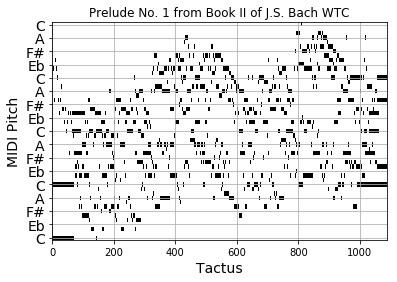

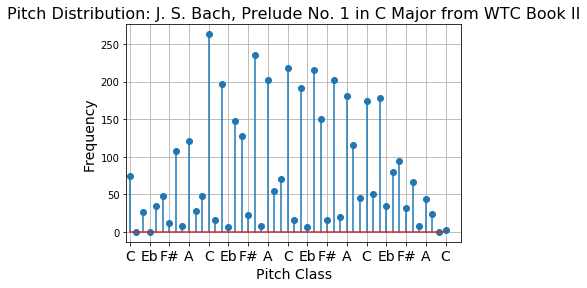

In [4]:
# Summarize a work as a pitch histogram, showing only the range of active pitches
# Load the first prelude in Book II of J.S. Bach's WTC
prelude1 = loadtxt('BachWTC1/49.ascii')
plot_mtx(prelude1)
t=title('Prelude No. 1 from Book II of J.S. Bach WTC')
figure()
pd = pitch_distribution(prelude1, 'J. S. Bach, Prelude No. 1 in C Major from WTC Book II')

<h2>Octave Folding for Pitch Class Histograms</h2> 

The above plot treats pitches in separate octaves as different pitches

It is more usual in tonal music analysis to ignore pitch height (octave) and to focus on pitch class
Here, we fold the score into a single octave and plot the pitch histogram for one octave


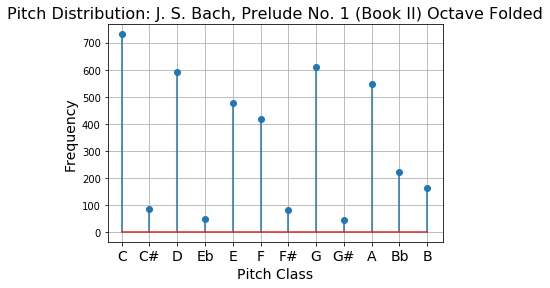

In [5]:
# Fold the above score into a single octave score matrix
prelude1_octave = fold_octaves(prelude1)
pd = pitch_distribution(prelude1_octave, 'J. S. Bach, Prelude No. 1 (Book II) Octave Folded')

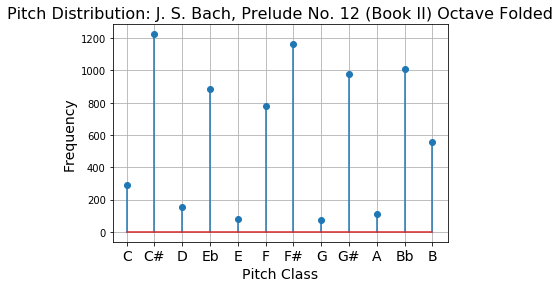

In [6]:
# Let's load a work in another key, say F# Major
prelude13 = loadtxt('BachWTC1/73.ascii')
prelude13_octave = fold_octaves(prelude13)
pd = pitch_distribution(prelude13_octave, 'J. S. Bach, Prelude No. 12 (Book II) Octave Folded')

<h2>Transposing a score</h2>

It is difficult to compare the pitch distribution of the Prelude in C Major with that of the Prelude in F# Major
because, obviously, they are in different keys.

To mitigate against the difference in keys, we can transpose a score by "rolling" the pitch axis downwards and circularly so that the pitches correspond to the key of C Major. For example, the Prelude No. 13 in F# Major can be rolled (transposed) by -6 half steps in the following way:


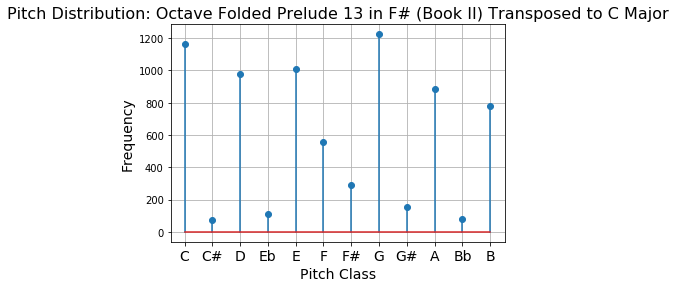

In [7]:
# Transpose the F# Prelude into the key of C Major
prelude13_transposed = roll(prelude13, -6, axis=0) # Roll the pitches (axis=0) down by six half steps (-6)
prelude13_transposed_octave = fold_octaves(prelude13_transposed)
pd = pitch_distribution(prelude13_transposed_octave, 'Octave Folded Prelude 13 in F# (Book II) Transposed to C Major')

<h1>Working with a Corpus</h1>
<h4>So far we have considered only one work at a time. Here we will investigate working with a corpus of works: the Well Tempered Clavier (WTC) Books 1 and 2 by J. S. Bach</h4>
<h4>WTC is organized into two books with 48 works each: a prelude and a fugue for every major and minor key in pitch class order: ['C','C#','D',...].</h4>
<h4>The WTC folder contains MIDI piano roll matrix representations of each work.</h4>

<h4>BOOK 1:</h4>
<ul>
<li>1.ascii = Prelude No. 1 in C Major
<li>2.ascii = Fugue No. 1 in C Major
<li>3.ascii = Prelude No. 2 in C Minor
<li>4.ascii = Fugue No. 2 in C Minor
<li>5.ascii = Prelude No. 3 in C# Major
<li>6.ascii = Fugue No. 3 in C# Major
<li>7.ascii = Prelude No. 4 in C# Minor
<li>8.ascii = Fugue No. 4 in C# Minor
<li>...
<li>47.ascii - Prelude No. 24 in B Minor
<li>48.ascii = Fugue No. 24 in B Minor
</ul>
<h4>BOOK 2:</h4>
<ul>
<li>49.ascii = Prelude No. 25 in C Major
<li>59.ascii = Fugue No. 25 in C Major
<li>...
<li>95.ascii = Prelude No. 48 in B Minor
<li>96.ascii = Fugue No. 48 in B Minor
</ul>



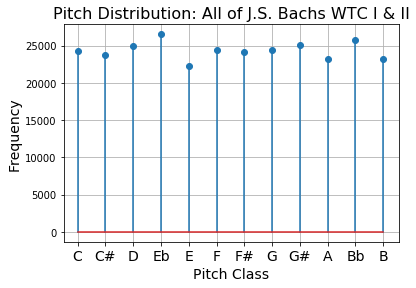

In [8]:
# LOAD ALL WTC works and show as a folde octaves pitch histogram
# We do this by loading each work into a list and then horizonally stacking them
# so that we get a 128 x T matrix, with T the total number of tacti (beats) in WTC I & II
allworks = [loadtxt(f) for f in sorted(glob.glob('BachWTC1/*.ascii'))] # Load ALL works
allworks_octave = fold_octaves( hstack(allworks) ) # stack horizontally and fold
pd = pitch_distribution(allworks_octave, "All of J.S. Bachs WTC I & II")

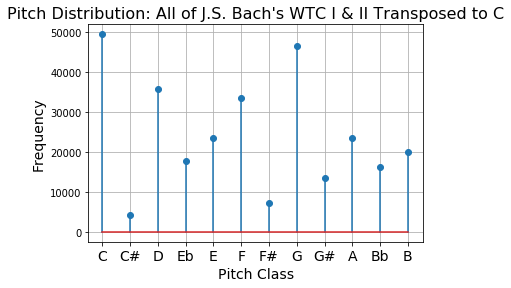

In [9]:
# The above distribution is for all works in their original keys, so it is relatively flat
# and not at all like the pitch distributions of Krumhansl and the note frequency charts we saw in class.
# What we need to do is transpose each work from its original key into C Major, so that we can look
# at pitch-class usage as RELATIVE to the KEY of each work, integrated across all works.

shifts = tile(repeat(arange(0,-12,-1),4),2) # Transpositions to C Major for every work
# The following line 'rolls' the columns (axis=0) by the transpositions, then splits octaves and sums them
# which folds all the octaves into one octave
allworks_transposed = hstack([fold_octaves(roll(s,t,axis=0)) for s,t in zip(allworks,shifts)])
# Show pitch distribution of the one-octave folded, C-transposed WTC I and II 
pd = pitch_distribution(allworks_transposed, "All of J.S. Bach's WTC I & II Transposed to C")

<h1>Question 1: Pitch distributions of Major Preludes, Minor Preludes, Major Fugues, Minor Fugures</h1>

A. Generate separate pitch distribution plots for each of the following:
    1. Major Preludes
    2. Minor Preludes
    3. Major Fugues
    4. Minor Fugues
    
B. 
    1. How well do the pitch distributions match with those of Prince and Schumuckler
"The Tonal-Metric Hierarchy: A Corpus Analysis", <i>Music Perception</i> 31(3):254-270 · February 2014
    2. How would you quantify the 'closeness' of the pitch distributions for each of the categories 1-4 above in WTC with the empirical distributions of classical music found in Prince and Schumuckler?
    3. OPTIONAL (GRADUATES) : go ahead and quantify the closeness between each of the categories of pitch distribution 1-4 with the distributions of Prince and Schumuckler.

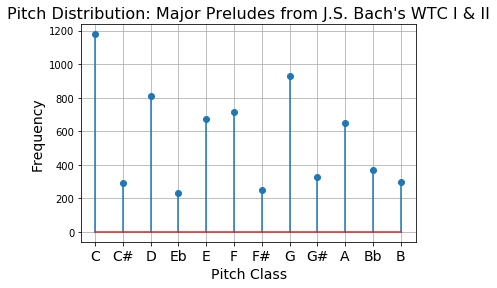

In [24]:
#iterative loading of files done with Shawn Ohazuruike

#Major Preludes
major_preludes = ['01', '05', '49']
ma_prelude_files = []
for i in range (0, 3): 
    ma_prelude_files.append('BachWTC1/' + major_preludes[i] + '.ascii')
ma_preludes_files = [loadtxt(file) for file in ma_prelude_files] #special thanks lloyd may for pointing out the obvious lines of code explaining this 3 cells below
ma_pre_works_octave = fold_octaves( hstack(ma_preludes_files) )
pd = pitch_distribution(ma_pre_works_octave, "Major Preludes from J.S. Bach's WTC I & II")

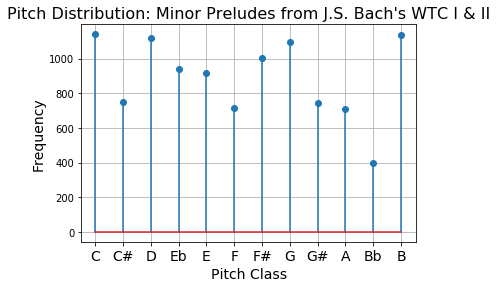

In [25]:
#Minor Preludes
minor_preludes = ['03', '07', '47', '95']
mi_prelude_files = []
for i in range (0, 4): 
    mi_prelude_files.append('BachWTC1/' + minor_preludes[i] + '.ascii')
mi_preludes_files = [loadtxt(file) for file in mi_prelude_files]
mi_pre_works_octave = fold_octaves( hstack(mi_preludes_files) )
pd = pitch_distribution(mi_pre_works_octave, "Minor Preludes from J.S. Bach's WTC I & II")

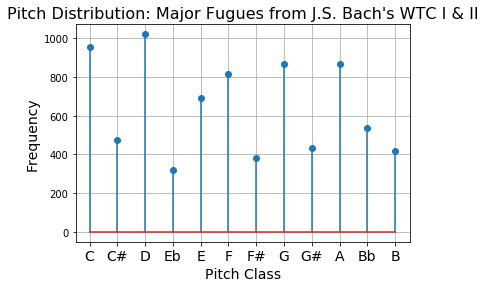

In [32]:
#Major Fugues
major_fugues = ['02', '06', '59']
ma_fugue_files = []
for i in range (0, 3): 
    ma_fugue_files.append('BachWTC1/' + major_fugues[i] + '.ascii')
ma_fugue_files = [loadtxt(file) for file in ma_fugue_files]
ma_fugue_works_octave = fold_octaves( hstack(ma_fugue_files) )
pd = pitch_distribution(ma_fugue_works_octave, "Major Fugues from J.S. Bach's WTC I & II")

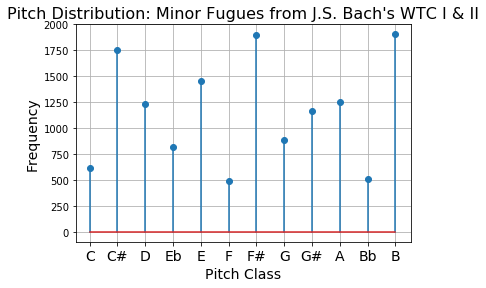

In [28]:
#Minor Fugues
minor_fugues = ['04', '08', '48', '95']
mi_fugue_files = []
for i in range (0, 4): 
    mi_fugue_files.append('BachWTC1/' + minor_fugues[i] + '.ascii')
mi_fugue_files = [loadtxt(file) for file in mi_fugue_files]
mi_fugue_works_octave = fold_octaves( hstack(mi_fugue_files) )
pd = pitch_distribution(mi_fugue_works_octave, "Minor Fugues from J.S. Bach's WTC I & II")

<h3>Answers to Part B Questions</h3> 

1. The pitch distributions for both Bach's Preludes and Fugues from the Well Tempered Clavier match Prince & Schumuckler's analysis of major keys quite well, but math the analysis of minor keys quite poorly. The trend of pitch occurence for both major preludes and fugues is accurate in Bach's work, apart from an increased use of 'F', the perfect fourth in the key of C Major, and a decreased use of 'B', the major seventh scale degree. For minor preludes and fugues, 'C', 'G' and 'A#' show up relatively less while 'C#', 'F#', 'G#' and 'B' turn up relatively more.
<br>

2. When quantifying closeness visually, the most telling result can be obtained by looking at the frequency occurence of each note relative to all others. In this way, the graph's data becomes incredibly easy to read. I would give both major preludes and fugues a score of 10/12 on closeness due to the similar trend absent of two notes in the octave, I would give both minor preludes and fugues a score of about 2/10. The graphs for Bach's work honestly do not make sense to me– I must have made some error with the code, but if so, I'm not sure why it's only affecting the minor-key selections.

In [33]:
# The following functions are for computing distances between 'observation' vectors 
# such as the vertical 'chords' in a temporally-integrated score

import scipy.spatial.distance as distance # scipy's distance function

# Use help(distance.pdist) to find out more about this very useful function

In [34]:
# We need the following function so that the principal component analysis (PCA) is 
# centered at the origin (0,0)
def center_mtx(D):
    """                                                                                                                                    
    Given a dissimilarity or dissonance matrix, center the matrix by subtracting the mean of                                               
    the rows and columns. For a dissimilarity matrix this operation yields the "scatter matrix".                                           
    """
    H = eye(D.shape[0]) - 1.0/D.shape[0]
    B = dot(dot(H,-0.5*D),H)
    return B

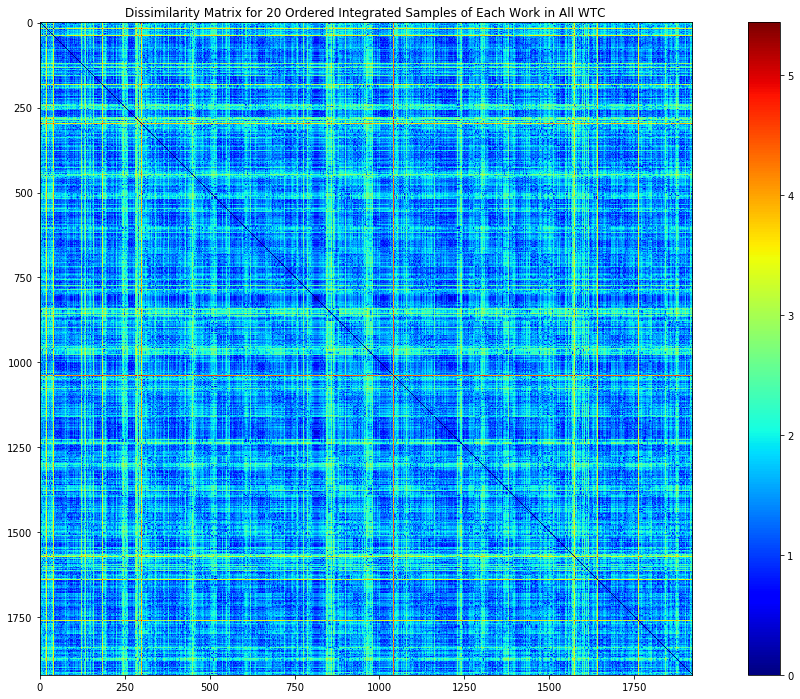

In [35]:
Ti=8 # temporal_integration
N=20 # Number of samples per work to take
# The next line uses slicing allworks[::4] to extract just the Major Preludes
# The Major Fugues would be allworks[1::4]
# The Minor Preludes would be allworks[2::4]
# The Minor Fugues would be allworks[3::4]
allworks_octave = fold_octaves(hstack([win_mtx(w,Ti)[:,sorted(randint(w.shape[1]/Ti,size=N))] for w in allworks]))
D = distance.pdist(allworks_octave.T, 'euclidean')
D = distance.squareform(D)
B = center_mtx(D)
figure(figsize=(20,12))
imshow(D, cmap=cm.jet)
title('Dissimilarity Matrix for 20 Ordered Integrated Samples of Each Work in All WTC')
colorbar()

In [13]:
D.sum(0).argmax()


295

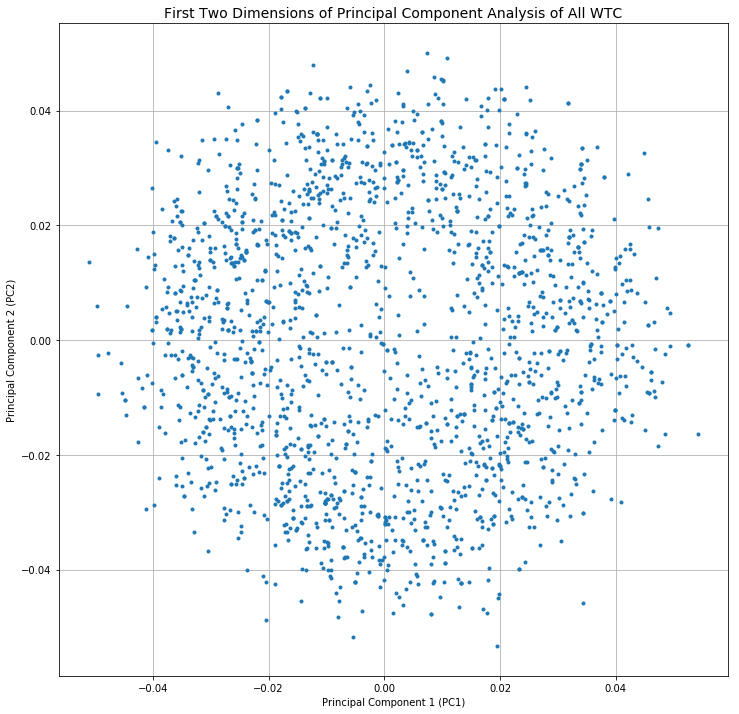

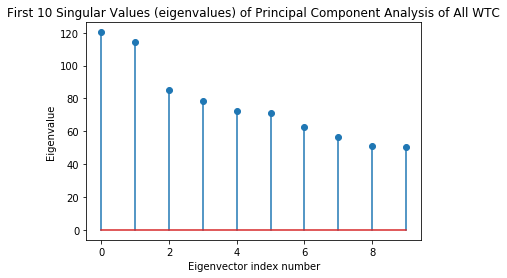

In [38]:
u,s,v = svd(B) # compute the principal component analysis for the 20 samples from each work (combined)
figure(figsize=(12,12))
plot(u[:,0],u[:,1],'.')
grid()
t=title('First Two Dimensions of Principal Component Analysis of All WTC', fontsize=14)
xlabel('Principal Component 1 (PC1)')
ylabel('Principal Component 2 (PC2)')
figure()
stem(s[:10])
xlabel('Eigenvector index number')
ylabel('Eigenvalue')
t=title('First 10 Singular Values (eigenvalues) of Principal Component Analysis of All WTC')

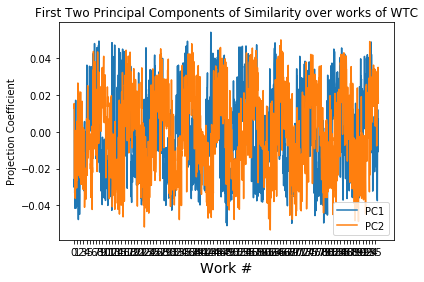

In [37]:
# Alternative view of the first two principle components, showing Sin and Cos pattern which creates the Circle of 5ths
# That is, the pattern of similarities over keys actually creates a circle in its first two eigenvectors!!
plot(u[:,0])
plot(u[:,1])
legend(['PC1','PC2'],fontsize=10)
xticks(arange(0,N*96,N),arange(96))
xlabel('Work #', fontsize=14)
ylabel('Projection Coefficient')
axis('tight')
t=title('First Two Principal Components of Similarity over works of WTC')

<h1>Question 2:</h1>

<h6>1. Write a paragraph or two on your understanding of the above analyses. (I know it is new and tricky): but answer at least the following:

    a. What does distance or dissimilarity actually mean in the above analysis?

    b. Is there a pattern in the dissimilarity matrix? What is it?

    c. What does the Principal Component Analysis (implemented with a Singular Value Decomposition) seem to do?

    d. What is your understanding of the axes (the first two principal components) in the figures just above?
</h6>

<h6>2. Do you get the same answers if you look at just the Major Preludes, Major Fugues, Minor Preludes, Minor Fugues? If not, why not do you think?</h6>


<h6>3. GRADUATE STUDENTS: Modify any of the above plots to give some type of different insight. Explain what you did, and what the result means. (Again, I know this is hard, but the point is to stretch your brain!).</h6><br>
- - - - - - - - - - - - - -

1. While the graphs do appear a bit mysterious to me, I think I have grasped at least the concept, if not the data. Distance, or dissimilarity between any two of the given samples is simply a measure of how similar the music in those keys is. One would expect, for example, music from the keys of C major and G major to be quite similar as they only have a one note difference– the substitution of an F# for an F. I struggled to read the top graph, however, the pattern that should be present represents the circle of fifths. Where's it present in the top graph? I couldn't tell you. The only pattern that is clearly present is that it is symmetrical over the diagonal– an obvious notion given that along this axis each sample is being compared against itself. The Principal Component Analysis seems to form a circle on which similar values are present. As this similarity matrix is two dimensional, it's possible that the analysis could form a torus in three dimensions– the conceptual shape in tonal space that keeps coming up. While I'm not too clear on the meaning of the axes, the general concept of principal component analysis is the reduction of a set of variables to a dimensionally smaller set that can more easily be analyzed while maintaining the effectiveness of the results.

<br>

2. If one were to look at just  the Major Preludes, Major Fugues, Minor Preludes, or Minor Fugues the answers should appear the same. The reason for this is the existence for parallel keys. If one were to do analysis on every major key versus every minor the same notes would be present. Every key in the chromatic scale would be present regardless. If analyzing Bach's WTC, though, the results might differ slightly. While I am not that familiar with this body of work, I assume that not all major and minor keys are used. This inbalance would result in some notes existing significantly less than others, likely changing the graphs' results.
